In [1]:
import pandas as pd
from pathlib import Path
import re
import sympy
from datetime import datetime
import os

In [2]:
def convert_to_function_notation(equations):
    """Convert Derivative(S, t) to Derivative(S(t), t) in equations"""
    t = sympy.Symbol('t')

    result = []
    for eq in equations:
        # LHS
        if isinstance(eq.lhs, sympy.Derivative):
            var = eq.lhs.args[0]  # This is S, E, etc.
            if isinstance(var, sympy.Symbol):
                func_name = str(var)
                func = sympy.Function(func_name)
                new_lhs = sympy.Derivative(func(t), t)
            else:
                new_lhs = eq.lhs
        else:
            new_lhs = eq.lhs
        
        # RHS
        state_vars = ['S', 'E', 'I', 'P', 'A', 'H', 'R', 'F']
        subs_dict = {}
        for var_name in state_vars:
            var = sympy.Symbol(var_name)
            if var in eq.rhs.free_symbols:
                func = sympy.Function(var_name)
                subs_dict[var] = func(t)
        
        new_rhs = eq.rhs.subs(subs_dict)
        result.append(sympy.Eq(new_lhs, new_rhs))
    
    return result


#### AI setup

In [3]:
# check API key
import os

api_key = os.environ.get("OPENAI_API_KEY")
if api_key:
    print("API key is set")
else:
    print("API key not found in environment variables")

API key is set


In [4]:
from mira.openai import OpenAIClient
from mira.sources.sympy_ode.llm_util import execute_template_model_from_sympy_odes, image_file_to_odes_str
client = OpenAIClient()

#### Extraction: image -> str

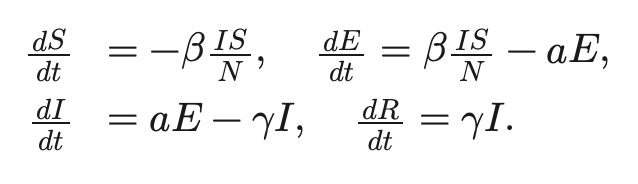

In [19]:
# Extract ODEs from image

biomodel_name = "BIOMD0000000956"

from IPython.display import Image
image_path = f'images/{biomodel_name}.png'
Image(image_path)

In [20]:
from mira.sources.sympy_ode.llm_util import (
    run_multi_agent_pipeline,
    execute_template_model_from_sympy_odes
)

corrected_ode_str, corrected_concepts, evaluation = run_multi_agent_pipeline(
    image_path,
    client,
    verbose=True,
    biomodel_name=biomodel_name
)

MULTI-AGENT ODE EXTRACTION & VALIDATION PIPELINE
Biomodel: BIOMD0000000956

PHASE 1: ODE Extraction from Image


INFO: [2025-09-15 11:31:41] httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  ODEs extracted from image
  Length: 456 characters

PHASE 2: Concept Grounding


INFO: [2025-09-15 11:31:44] httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  Extracted 4 concepts

PHASE 3: Execution Error Correction
  No execution errors found

PHASE 4: Validation Checks
  Running parameter and time-dependency validation...


INFO: [2025-09-15 11:31:51] httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO: [2025-09-15 11:31:54] httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  Running mathematical validation...


INFO: [2025-09-15 11:32:03] httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO: [2025-09-15 11:32:15] httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  No validation issues found

PHASE 5: Unified Error Correction
  No corrections needed

PHASE 6: Quantitative Evaluation (Comparison-Based)
  Biomodel: BIOMD0000000956
  Execution Success: PASS (100%)
  Equation Accuracy: 2/4 equations match (50.0%)
  Overall Score: 65.0%
  Status: NEEDS IMPROVEMENT

  Non-matching equations (first 3):
    Equation 0: Difference = (-a + alpha)*E(t)
    Equation 1: Difference = (a - alpha)*E(t)
PIPELINE COMPLETE


In [ ]:
# Results based on quantitative evaluation in the last phase of the multi-agent pipeline

print("\n" + "="*60)
print("EVALUATION SUMMARY")
print("="*60)
print(f"Execution Success: {evaluation['execution_success_rate']:.0%}")
print(f"Equation Accuracy: {evaluation['equation_accuracy_rate']:.1%}")
print(f"Equations Checked: {evaluation.get('num_equations_checked', 0)}")

# Display all comparison details
print("\n" + "="*60)
print("DETAILED EQUATION COMPARISON")
print("="*60)

if 'comparison_details' in evaluation and evaluation['comparison_details']:
    details = evaluation['comparison_details']
    
    # Count matches and mismatches
    matches = sum(1 for d in details if isinstance(d, dict) and d.get('match', False))
    mismatches = len(details) - matches
    
    print(f"Total Equations: {len(details)}")
    print(f"Matching: {matches}")
    print(f"Mismatched: {mismatches}")
    print("-"*60)
    
    # Print each equation comparison
    for i, detail in enumerate(details):
        if isinstance(detail, dict):
            print(f"\n[Equation {i+1}]")
            
            # Check if error occurred
            if 'error' in detail:
                print(f"  ERROR: {detail['error']}")
                continue
            
            # Print match status
            match_status = "✓ MATCH" if detail.get('match', False) else "✗ MISMATCH"
            print(f"  Status: {match_status}")
            
            # Print correct equation
            if 'correct' in detail:
                print(f"  Correct:   {detail['correct']}")
            
            # Print extracted equation
            if 'extracted' in detail:
                print(f"  Extracted: {detail['extracted']}")
            
            # Print difference (if mismatch)
            if not detail.get('match', False) and 'difference' in detail:
                diff_str = str(detail['difference'])
                # Truncate very long differences
                if len(diff_str) > 200:
                    diff_str = diff_str[:200] + "..."
                print(f"  Difference: {diff_str}")
else:
    print("No comparison details available.")
    print("Make sure the correct equations TSV file is accessible and contains this biomodel.")

print("\n" + "="*60)
print("CORRECTED ODE STRING")
print("="*60)
print(corrected_ode_str)


EVALUATION SUMMARY
Overall Score: 65.00%
Execution Success: 100%
Equation Accuracy: 50.0%
Equations Checked: 4

DETAILED EQUATION COMPARISON
Total Equations: 4
Matching: 2
Mismatched: 2
------------------------------------------------------------

[Equation 1]
  Status: ✗ MISMATCH
  Correct:   Eq(Derivative(E(t), t), -alpha*E(t) + beta*I(t)*S(t)/N)
  Extracted: Eq(Derivative(E(t), t), -a*E(t) + beta*I(t)*S(t)/N)
  Difference: (-a + alpha)*E(t)

[Equation 2]
  Status: ✗ MISMATCH
  Correct:   Eq(Derivative(I(t), t), alpha*E(t) - gamma*I(t))
  Extracted: Eq(Derivative(I(t), t), a*E(t) - gamma*I(t))
  Difference: (a - alpha)*E(t)

[Equation 3]
  Status: ✓ MATCH
  Correct:   Eq(Derivative(R(t), t), gamma*I(t))
  Extracted: Eq(Derivative(R(t), t), gamma*I(t))

[Equation 4]
  Status: ✓ MATCH
  Correct:   Eq(Derivative(S(t), t), -beta*I(t)*S(t)/N)
  Extracted: Eq(Derivative(S(t), t), -beta*I(t)*S(t)/N)

CORRECTED ODE STRING
import sympy

# Define time variable
t = sympy.symbols("t")

# Define

In [22]:
tm = execute_template_model_from_sympy_odes(
    corrected_ode_str,
    corrected_concepts  
)

print("tm type:", type(tm))
print("tm has templates:", hasattr(tm, 'templates'))

# Check what's in the templates
print(f"Number of templates: {len(tm.templates)}")
print("\nTemplate details:")
for i, template in enumerate(tm.templates):
    print(f"\nTemplate {i}: {template.name if hasattr(template, 'name') else 'unnamed'}")
    print(f"  Type: {type(template)}")
    print(f"  Rate: {template.rate if hasattr(template, 'rate') else 'no rate'}")
    print(f"  Rate type: {type(template.rate) if hasattr(template, 'rate') else 'N/A'}")
    
    # Check for transitions (if this is a transition-based template)
    if hasattr(template, 'subject'):
        print(f"  Subject: {template.subject}")
    if hasattr(template, 'outcome'):
        print(f"  Outcome: {template.outcome}")
    if hasattr(template, 'consumed'):
        print(f"  Consumed: {template.consumed}")
    if hasattr(template, 'produced'):
        print(f"  Produced: {template.produced}")

tm type: <class 'mira.metamodel.template_model.TemplateModel'>
tm has templates: True
Number of templates: 3

Template details:

Template 0: None
  Type: <class 'mira.metamodel.templates.ControlledConversion'>
  Rate: no rate
  Rate type: N/A
  Subject: name='S' display_name=None description=None identifiers={'ido': '0000514'} context={'status': 'susceptible', 'species': 'ncbitaxon:9606'} units=None
  Outcome: name='E' display_name=None description=None identifiers={'apollosv': '00000154'} context={'status': 'exposed', 'species': 'ncbitaxon:9606'} units=None

Template 1: None
  Type: <class 'mira.metamodel.templates.NaturalConversion'>
  Rate: no rate
  Rate type: N/A
  Subject: name='E' display_name=None description=None identifiers={'apollosv': '00000154'} context={'status': 'exposed', 'species': 'ncbitaxon:9606'} units=None
  Outcome: name='I' display_name=None description=None identifiers={'ido': '0000511'} context={'status': 'infected', 'species': 'ncbitaxon:9606'} units=None

Tem

In [ ]:
import os
from datetime import datetime

def save_comparison_results(
    evaluation: dict,
    corrected_ode_str: str,
    corrected_concepts: dict,
    mtx_odes_sympy: list,
    tm,  # Template model
    biomodel_name: str,
    folder_path: str = "/Users/kovacs.f/Desktop/mira/notebooks/equation extraction development/extraction error check/string mismatch check/comparison_results"
):
    """
    Save detailed comparison results to markdown file
    
    Args:
        evaluation: The evaluation dictionary from pipeline
        corrected_ode_str: The final corrected ODE string
        corrected_concepts: The corrected concepts dictionary
        mtx_odes_sympy: Matrix ODEs from template model
        tm: Template model for extracting final concepts
        biomodel_name: Name of the biomodel
        folder_path: Path to save results
    """
    # Create folder if it doesn't exist
    os.makedirs(folder_path, exist_ok=True)
    
    # Generate timestamp
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    
    # Create filename
    file_path = os.path.join(folder_path, f"{biomodel_name}_comparison_{timestamp}.md")
    
    with open(file_path, 'w', encoding='utf-8') as f:
        # Header
        f.write(f"# Equation Extraction Comparison Report\n")
        f.write(f"## Model: {biomodel_name}\n")
        f.write(f"### Generated: {timestamp}\n\n")
        
        # Scores
        f.write("## Evaluation Scores\n\n")
        f.write(f"- **Execution Success**: {evaluation.get('execution_success_rate', 0):.0%}\n")
        f.write(f"- **Equation Accuracy**: {evaluation.get('equation_accuracy_rate', 0):.1%}\n")
        f.write(f"- **Equations Checked**: {evaluation.get('num_equations_checked', 0)}\n\n")
        
        # Detailed equation comparison
        f.write("## Detailed Equation-by-Equation Comparison\n\n")
        
        if 'comparison_details' in evaluation and evaluation['comparison_details']:
            details = evaluation['comparison_details']
            
            # Summary statistics
            matches = sum(1 for d in details if isinstance(d, dict) and d.get('match', False))
            mismatches = len(details) - matches
            
            f.write(f"**Summary**: {matches}/{len(details)} equations match correctly\n\n")
            
            # Each equation
            for i, detail in enumerate(details):
                if isinstance(detail, dict):
                    f.write(f"### Equation {i+1}\n\n")
                    
                    # Handle errors
                    if 'error' in detail:
                        f.write(f"**ERROR**: {detail['error']}\n\n")
                        continue
                    
                    # Match status
                    match_status = "**MATCH**" if detail.get('match', False) else "**MISMATCH**"
                    f.write(f"**Status**: {match_status}\n\n")
                    
                    # Equations
                    if 'correct' in detail:
                        f.write(f"**Ground Truth**:\n```python\n{detail['correct']}\n```\n\n")
                    
                    if 'extracted' in detail:
                        f.write(f"**Extracted**:\n```python\n{detail['extracted']}\n```\n\n")
                    
                    # Difference (if mismatch)
                    if not detail.get('match', False) and 'difference' in detail:
                        f.write(f"**Difference**:\n```python\n{detail['difference']}\n```\n\n")
                    
                    f.write("---\n\n")
        else:
            f.write("No comparison details available.\n\n")
        
        # Corrected ODE string
        f.write("## Final Corrected ODE String\n\n")
        f.write("```python\n")
        f.write(corrected_ode_str)
        f.write("\n```\n\n")
        
        # Matrix ODEs from template model
        if mtx_odes_sympy:
            f.write("## Template Model Matrix ODEs\n\n")
            f.write("```python\n")
            for eq in mtx_odes_sympy:
                f.write(f"{eq}\n")
            f.write("```\n\n")

        # Template model concepts
        f.write("## Template Model Concepts\n\n")
        if tm and hasattr(tm, 'get_concepts_map'):
            concepts_map = tm.get_concepts_map()
            if concepts_map:
                f.write("| Concept Name | Identifiers | Context |\n")
                f.write("|--------------|-------------|----------|\n")
                for concept in concepts_map.values():
                    name = concept.name if hasattr(concept, 'name') else 'N/A'
                    identifiers = str(concept.identifiers) if hasattr(concept, 'identifiers') else 'N/A'
                    context = str(concept.context) if hasattr(concept, 'context') else 'N/A'
                    # Escape pipe characters in cell content
                    identifiers = identifiers.replace('|', '\\|')
                    context = context.replace('|', '\\|')
                    f.write(f"| {name} | {identifiers} | {context} |\n")
                f.write("\n")
            else:
                f.write("No concepts in template model.\n\n")
        else:
            f.write("Template model not available or has no concepts.\n\n")
    
        
        # Error details if present
        if 'error' in evaluation:
            f.write("## Errors\n\n")
            f.write(f"**Error**: {evaluation['error']}\n\n")
        return file_path


file_path = save_comparison_results(
    evaluation=evaluation,
    corrected_ode_str=corrected_ode_str,
    corrected_concepts=corrected_concepts,
    mtx_odes_sympy=mtx_odes_sympy,
    tm=tm, 
    biomodel_name=biomodel_name,
    folder_path='/Users/kovacs.f/Desktop/mira/notebooks/equation extraction development/extraction error check/string mismatch check/comparison_results'
)

print(f"\nComparison results saved to: {file_path}")


Comparison results saved to: /Users/kovacs.f/Desktop/mira/notebooks/equation extraction development/extraction error check/string mismatch check/comparison_results/BIOMD0000000956_comparison_2025-09-15_11-32-15.md


In [24]:
from mira.modeling import Model
from mira.modeling.ode import OdeModel
om = OdeModel(Model(tm), initialized=True)
mtx_sympy = om.get_interpretable_kinetics()

mtx_odes_sympy = []
for i in range(mtx_sympy.shape[0]):
    lhs = mtx_sympy[i,0]
    rhs = mtx_sympy[i,2]
    mtx_odes_sympy.append(sympy.Eq(lhs, rhs))

mtx_odes_sympy = convert_to_function_notation(mtx_odes_sympy)


print("\nMatrix ODEs:")
for eq in mtx_odes_sympy:
    print(f"  {eq}")


Matrix ODEs:
  Eq(Derivative(S(t), t), -beta*I(t)*S(t)/N)
  Eq(Derivative(I(t), t), a*E(t) - gamma*I(t))
  Eq(Derivative(E(t), t), -a*E(t) + beta*I(t)*S(t)/N)
  Eq(Derivative(R(t), t), gamma*I(t))


In [25]:
# Check the concepts
print('concept name\tidentifiers\tcontext')
for concept in tm.get_concepts_map().values():
    print(f'{concept.name}\t{concept.identifiers}\t{concept.context}')

concept name	identifiers	context
S	{'ido': '0000514'}	{'status': 'susceptible', 'species': 'ncbitaxon:9606'}
E	{'apollosv': '00000154'}	{'status': 'exposed', 'species': 'ncbitaxon:9606'}
I	{'ido': '0000511'}	{'status': 'infected', 'species': 'ncbitaxon:9606'}
R	{'ido': '0000592'}	{'status': 'recovered', 'species': 'ncbitaxon:9606'}
